## Image Classifier for the SVHN Sataset

This notebook project creates a neural network that classifies real-world images of digits. It utilizes concepts such as training, testing, validating, and saving a TensorFlow classifier model.

First, run some imports and load the dataset:

In [1]:
import tensorflow as tf
from scipy.io import loadmat

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



For this project, we use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets needed for this project can be downloaded from the following links:
* [Train Dataset](http://ufldl.stanford.edu/housenumbers/train.tar.gz)
* [Test Dataset](http://ufldl.stanford.edu/housenumbers/test.tar.gz)

After the files are downloaded and unzipped, two files will be found: train_32x32.mat and test_32x32.mat. These files should be saved in your Google Drive for use in the Colab notebook.

The goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Load the dataset from your Drive folder

train = loadmat('path/to/train_32x32.mat')
test = loadmat('path/to/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and Preprocess the Dataset
In the code below:
* The training and testing images and labels are extracted separately from the train and test dictionaries.
* A random sample of at least 10 images and their corresponding labels are selected from the dataset and displayed in a figure.
* The training and testing images are converted to grayscale by averaging the color channels for each pixel.
* A random sample of at least 10 grayscale images and their corresponding labels are selected from the dataset and displayed in a figure.

In [3]:
# Extract images and labels
X_train, y_train = train['X'], train['y']
X_test, y_test = test['X'], test['y']

In [4]:
# Reshape the data
X_train = np.transpose(X_train, (3, 0, 1, 2))
X_test = np.transpose(X_test, (3, 0, 1, 2))

In [5]:
# Correct the labels for '0' digit
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

In [6]:
# Display random sample images
def display_random_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, 10, figsize=(15, 15))
    indices = np.random.randint(0, X.shape[0], 10)
    for i, idx in enumerate(indices):
        img = X[idx]
        if grayscale:
            img = img.squeeze(axis=-1)
        axes[i].imshow(img, cmap='gray' if grayscale else None)
        axes[i].set_title(y[idx][0])
        axes[i].axis('off')
    plt.show()

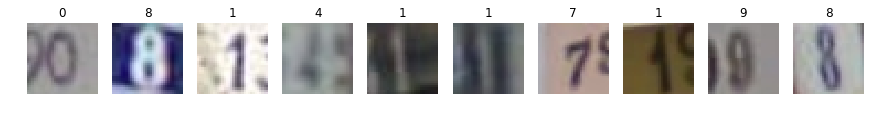

In [7]:
# Display original images
display_random_images(X_train, y_train)


In [8]:
# Convert images to grayscale
X_train_gray = np.mean(X_train, axis=-1, keepdims=True)
X_test_gray = np.mean(X_test, axis=-1, keepdims=True)


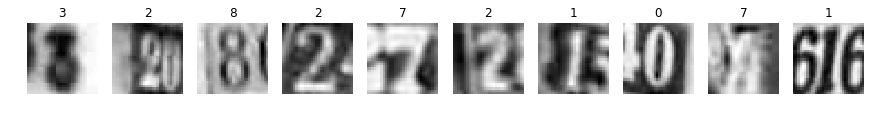

In [9]:
# Display grayscale images
display_random_images(X_train_gray, y_train, grayscale=True)


In [10]:
# Normalize the images
X_train_gray = X_train_gray / 255.0
X_test_gray = X_test_gray / 255.0


In [11]:
# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


In [12]:
# Function to get callbacks
def get_callbacks(checkpoint_path='best_model.h5', monitor='val_loss', mode='min', patience=5):
    checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor=monitor, mode=mode)
    early_stopping = EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=True)
    return checkpoint, early_stopping


In [13]:
# Plot learning curves
def plot_learning_curves(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(history.history['loss'], label='Train Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].legend()
    ax[0].set_title('Loss vs Epochs')
    ax[1].plot(history.history['accuracy'], label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[1].legend()
    ax[1].set_title('Accuracy vs Epochs')
    plt.show()


## 2. MLP Neural Network Classifier
In the code below:
* An MLP classifier model is built using the Sequential API. The model consists of Flatten and Dense layers, with the final layer having a 10-way softmax output.
* The model summary is printed using the `summary()` method.
* The model is compiled and trained, utilizing both training and validation sets during the training process.
* At least one appropriate metric is tracked, and at least two callbacks are used during training, one of which is a `ModelCheckpoint` callback.
* The learning curves for loss vs. epoch and accuracy vs. epoch for both training and validation sets are plotted.
* The loss and accuracy of the trained model on the test set are computed and displayed.
* A final categorical cross-entropy training loss of less than 1.0 is aimed for (the validation loss might be higher).

In [14]:
# MLP Model
mlp_model = Sequential([
    Flatten(input_shape=(32, 32, 1)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])


In [15]:
# Print the model summary
mlp_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 690,314
Trainable params: 690,314
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Compile the MLP model
mlp_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


In [17]:
# Get callbacks for MLP
checkpoint, early_stopping = get_callbacks(checkpoint_path='mlp_best_model.h5')


In [18]:
# Train the MLP model
mlp_history = mlp_model.fit(X_train_gray, y_train, epochs=30, validation_split=0.2, callbacks=[checkpoint, early_stopping])


Train on 58605 samples, validate on 14652 samples
Epoch 1/30
58605/58605 [==============================] - 76s 1ms/sample - loss: 2.1199 - accuracy: 0.2341 - val_loss: 1.9411 - val_accuracy: 0.2933
Epoch 2/30
58605/58605 [==============================] - 72s 1ms/sample - loss: 1.8064 - accuracy: 0.3595 - val_loss: 1.6646 - val_accuracy: 0.4251
Epoch 3/30
58605/58605 [==============================] - 71s 1ms/sample - loss: 1.5460 - accuracy: 0.4657 - val_loss: 1.4719 - val_accuracy: 0.5018
Epoch 4/30
58605/58605 [==============================] - 72s 1ms/sample - loss: 1.4380 - accuracy: 0.5102 - val_loss: 1.4154 - val_accuracy: 0.5248
Epoch 5/30
58605/58605 [==============================] - 72s 1ms/sample - loss: 1.3978 - accuracy: 0.5267 - val_loss: 1.3943 - val_accuracy: 0.5317
Epoch 6/30
58605/58605 [==============================] - 73s 1ms/sample - loss: 1.3747 - accuracy: 0.5361 - val_loss: 1.3600 - val_accuracy: 0.5471
Epoch 7/30
58605/58605 [==============================] 

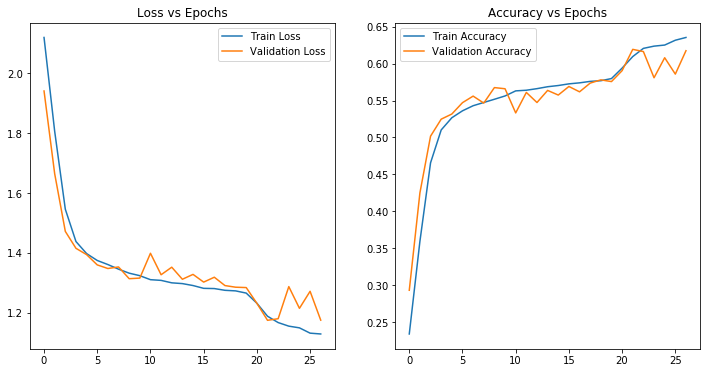

In [19]:
# Plot learning curves for MLP
plot_learning_curves(mlp_history)


In [20]:
# Evaluate the MLP model on the test set

mlp_test_loss, mlp_test_acc = mlp_model.evaluate(X_test_gray, y_test, verbose=0)
print(f"MLP Test Loss: {mlp_test_loss:.4f}")
print(f"MLP Test Accuracy: {mlp_test_acc:.4f}")


MLP Test Loss: 1.2870
MLP Test Accuracy: 0.5929


## 3. CNN Neural Network Classifier
In the code below:
* A CNN classifier model is built using the Sequential API. The model uses Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, and Dropout layers. The final layer has a 10-way softmax output.
* The CNN model uses fewer trainable parameters than the MLP model.
* The model is compiled and trained, using both training and validation sets during the training run.
* The model tracks at least one appropriate metric and uses at least two callbacks during training, one of which is a `ModelCheckpoint` callback.
* The aim is to outperform the MLP model with fewer parameters.
* Learning curves are plotted for loss vs. epoch and accuracy vs. epoch for both training and validation sets.
* The loss and accuracy of the trained model are computed and displayed on the test set.

In [21]:
# CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    MaxPool2D((2, 2)),
    BatchNormalization(),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    BatchNormalization(),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Print the model summary
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 6, 64)         

In [22]:
# Compile the CNN model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [23]:
# Get callbacks for CNN
checkpoint, early_stopping = get_callbacks(checkpoint_path='cnn_best_model.h5')


In [24]:
# Train the CNN model
cnn_history = cnn_model.fit(X_train_gray, y_train, epochs=20, validation_split=0.2, callbacks=[checkpoint, early_stopping])


Train on 58605 samples, validate on 14652 samples
Epoch 1/20
58605/58605 [==============================] - 435s 7ms/sample - loss: 1.0550 - accuracy: 0.6833 - val_loss: 0.4998 - val_accuracy: 0.8504
Epoch 2/20
58605/58605 [==============================] - 431s 7ms/sample - loss: 0.6245 - accuracy: 0.8084 - val_loss: 0.4909 - val_accuracy: 0.8572
Epoch 3/20
58605/58605 [==============================] - 432s 7ms/sample - loss: 0.5640 - accuracy: 0.8275 - val_loss: 0.4690 - val_accuracy: 0.8669
Epoch 4/20
58605/58605 [==============================] - 430s 7ms/sample - loss: 0.5276 - accuracy: 0.8398 - val_loss: 0.3743 - val_accuracy: 0.8913
Epoch 5/20
58605/58605 [==============================] - 428s 7ms/sample - loss: 0.4945 - accuracy: 0.8469 - val_loss: 0.4638 - val_accuracy: 0.8681oss: 0.4945 - accuracy: 0.84
Epoch 6/20
58605/58605 [==============================] - 431s 7ms/sample - loss: 0.4681 - accuracy: 0.8555 - val_loss: 0.4139 - val_accuracy: 0.8769
Epoch 7/20
58605/58605

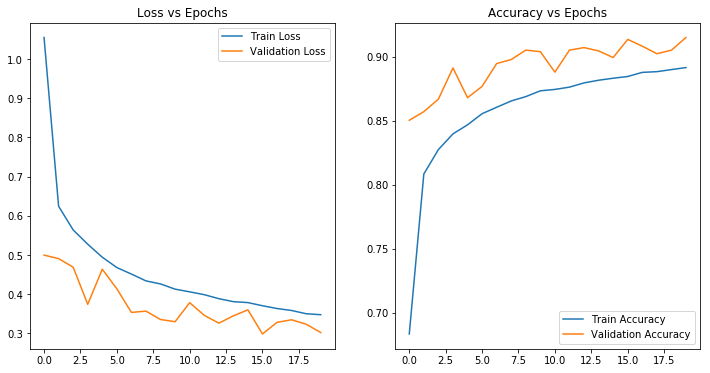

In [25]:
# Plot learning curves for CNN
plot_learning_curves(cnn_history)

In [26]:
# Evaluate the CNN model on the test set
# cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test_gray, y_test)
# print(f"CNN Test Loss: {cnn_test_loss:.4f}")
# print(f"CNN Test Accuracy: {cnn_test_acc:.4f}")

# Evaluate the CNN model on the test set
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test_gray, y_test, verbose=0)
print(f"CNN Test Loss: {cnn_test_loss:.4f}")
print(f"CNN Test Accuracy: {cnn_test_acc:.4f}")

CNN Test Loss: 0.3243
CNN Test Accuracy: 0.9085


## 4. Get Model Predictions
In the code below:
* The best weights for the MLP and CNN models that were saved during the training run are loaded.
* Five images and their corresponding labels are randomly selected from the test set, and the images with their labels are displayed.
* Alongside the image and label, each model’s predictive distribution is shown as a bar chart, and the final model prediction, given by the label with maximum probability, is displayed.

In [27]:
# Load the best weights
mlp_model.load_weights('mlp_best_model.h5')
cnn_model.load_weights('cnn_best_model.h5')

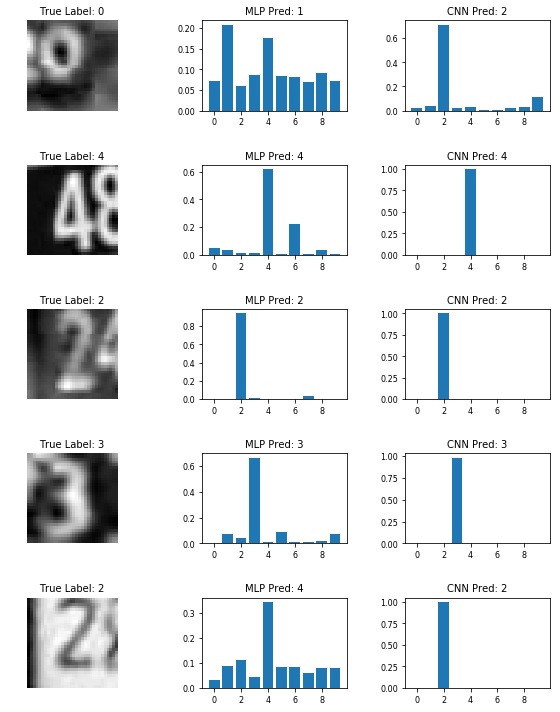

In [28]:
# Function to display images with predictions
def display_predictions(X, y, mlp_model, cnn_model, num_images=5):
    indices = np.random.randint(0, X.shape[0], num_images)
    fig, axes = plt.subplots(num_images, 3, figsize=(8, 2*num_images))
    
    for i, idx in enumerate(indices):
        img = X[idx].squeeze()
        true_label = np.argmax(y[idx])
        
        # Predict with MLP model
        mlp_pred = mlp_model.predict(np.expand_dims(X[idx], axis=0))
        mlp_pred_label = np.argmax(mlp_pred)
        
        # Predict with CNN model
        cnn_pred = cnn_model.predict(np.expand_dims(X[idx], axis=0))
        cnn_pred_label = np.argmax(cnn_pred)
        
        # Display image
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f"True Label: {true_label}", fontsize=10)
        axes[i, 0].axis('off')
        
        # Display MLP prediction
        axes[i, 1].bar(range(10), mlp_pred[0])
        axes[i, 1].set_title(f"MLP Pred: {mlp_pred_label}", fontsize=10)
        axes[i, 1].tick_params(axis='x', labelsize=8)
        axes[i, 1].tick_params(axis='y', labelsize=8)
        
        # Display CNN prediction
        axes[i, 2].bar(range(10), cnn_pred[0])
        axes[i, 2].set_title(f"CNN Pred: {cnn_pred_label}", fontsize=10)
        axes[i, 2].tick_params(axis='x', labelsize=8)
        axes[i, 2].tick_params(axis='y', labelsize=8)
        
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    plt.show()

# Display predictions
display_predictions(X_test_gray, y_test, mlp_model, cnn_model)